In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns


In [31]:
df = pd.read_csv('gd.csv', delimiter=';')

In [32]:
#df.insert(0, 'ones', 1.)

In [33]:
np.ones(df.shape[1])

array([1., 1., 1.])

In [34]:
df.y = df.y * np.random.rand(df.shape[0])
df

,x,y,iter
0,5.000000,4.069547,0
1,4.000000,3.479041,1
2,3.375300,3.324522,2
3,2.908990,0.056172,3
4,2.536090,0.359584,4
...,...,...,...
87,0.000235,0.000039,87
88,0.000210,0.000047,88
89,0.000188,0.000026,89
90,0.000169,0.000050,90


In [35]:
df = df.drop(columns = 'iter')

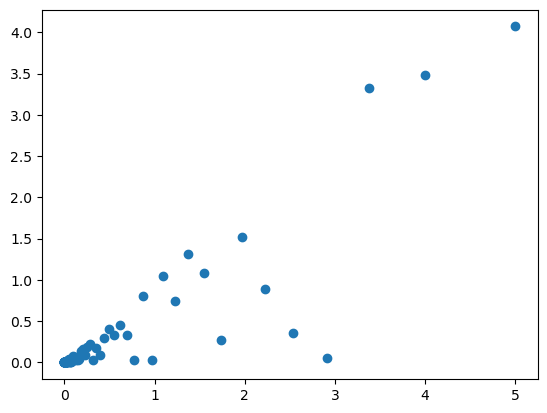

In [36]:
plt.scatter(df.x, df.y)

In [37]:
x = df.drop(columns = 'y')
y = df.y
weights = np.ones(x.shape[1])
weights

array([1.])

In [38]:

2/x.shape[0] * np.dot((np.dot(x, weights)-y), x)


array([0.67696439])

In [72]:
sigmoid = lambda x, w: [1/(1+np.exp(-np.dot(x.loc[xi], w))) for xi in x.index]

def accuracy(fx, y):
    return (fx == y)/len(y)
def precision(fx, y):
    fp = 0
    tp = 0
    
    for i in fx:
        if fx == y == 1:
            tp +=1
        elif (fx == 1) and (y == -1):
            fp+=1
    return tp/(tp+fp)
def recall(fx, y):
    fn = 0
    tp = 0
    
    for i in fx: 
        if fx == y == 1:
            tp +=1
        elif (fx == -1) and (y == 1):
            fn +=1
    return tp/(tp+fn)

def f1(fx, y):
    p = precision(fx, y)
    r = recall(fx, y)
    return 2 * p * r / (p + r)

def roc_auc(fx, y):
    pass

class MyLogReg():
    
    weights = []
    score = 0

    
    def __init__(self, n_iter, learning_rate):
        self.n = n_iter
        self.lr = learning_rate

    def fit(self, x, y, verbose = False):
        grad = lambda x, y, w: 1/x.shape[0] * np.dot((sigmoid(x, w)-y), x)
        X = x.copy()
            
        X.insert(0, 'ones', 1.)
        self.weights = np.ones(X.shape[1])
        for i in range(self.n):
            g = grad(X, y, self.weights) 
            self.weights = self.weights - self.lr * g  
                  
    def predict(self, X):
        x = X.copy()
        x.insert(0, 'ones', 1.)
        preds = sigmoid(x, self.weights)
        ans = []
        for i in preds:
            if i >0.5:
                ans.append(1)
            else:ans.append(0)
        return ans
        
    
    def predict_proba(self, X):
        x = X.copy()
        x.insert(0, 'ones', 1.)
        return sigmoid(x, self.weights)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns



In [41]:
df = pd.read_csv('data/Raisin_Dataset.csv')
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [42]:
df.Class.unique()

array(['Kecimen', 'Besni'], dtype=object)

In [43]:
df.Class = df.Class.map({'Kecimen':-1, 'Besni': 1})

<Axes: >

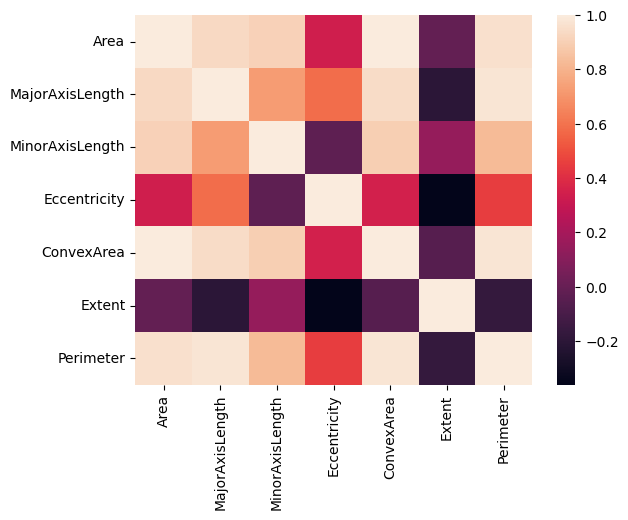

In [44]:
sns.heatmap(df.drop(columns = 'Class').corr())

In [45]:
x = df.drop(columns = 'Class')
y = df.Class

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=47)

In [79]:
lr = LogisticRegression()

In [80]:
lr.fit(x_train, y_train)

d:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [81]:
lr.score(x_test, y_test)

0.8703703703703703

In [92]:
preds = lr.predict_proba(x_test)[::, 1]
preds

array([0.99997289, 0.40419364, 0.36961231, 0.10488014, 0.04372632,
       0.75629954, 0.49156822, 0.48445704, 0.44877054, 0.96277401,
       0.16105572, 0.99999956, 0.99969827, 0.73158526, 0.72603828,
       0.16197675, 0.12351477, 0.98048724, 0.25986049, 0.79886454,
       0.93027012, 0.99721963, 0.13280718, 0.23873084, 0.01802203,
       0.99358695, 0.08924395, 0.69198513, 0.46454848, 0.22101364,
       0.20670923, 0.71715591, 0.99994638, 0.99117046, 0.99330425,
       0.52702031, 0.49436603, 0.8815687 , 0.91707302, 0.67978112,
       0.71710432, 0.12742174, 0.57223539, 0.92836907, 0.08215662,
       0.44428814, 0.22521812, 0.99825593, 0.32314277, 0.68823673,
       0.67034517, 0.90210112, 0.9960364 , 0.53465237, 0.50656236,
       0.58940694, 0.68704052, 0.56464057, 0.32734601, 0.98506931,
       0.99997921, 0.38126552, 0.18934418, 0.30236756, 0.08569011,
       0.06333185, 0.44550304, 0.84365065, 0.40645049, 0.9771576 ,
       0.88646756, 0.19999172, 0.77404806, 0.03514147, 0.27973

In [95]:
data = pd.DataFrame([preds, y_test], index = ['probs', 'classes']).T
data

,probs,classes
0,0.999973,1.0
1,0.404194,-1.0
2,0.369612,-1.0
3,0.104880,-1.0
4,0.043726,-1.0
...,...,...
265,0.999996,1.0
266,0.996582,1.0
267,0.577902,1.0
268,0.059463,-1.0


In [97]:
data.sort_values(by = 'probs', ascending=False)

,probs,classes
108,1.000000,1.0
158,1.000000,1.0
11,1.000000,1.0
228,0.999997,1.0
201,0.999996,1.0
...,...,...
170,0.018844,-1.0
24,0.018022,-1.0
160,0.015807,-1.0
252,0.015453,-1.0


In [132]:
def sign(x, t):
    ans = []
    for xi in x:
        if xi - t > 0:
            ans.append(1)
        else: ans.append(-1)
    return ans
        
def fpr(sx, y):
    a = 0
    
    for i in range(len(sx)):
        if (y[i] == -1) and (sx[i] == 1):
            a+=1
        
    return a / (y == -1).sum()
def tpr(sx, y):
    fn = 0
    tp = 0
    
    for i in range(len(sx)): 
        if sx[i] == y[i] == 1:
            tp +=1
        elif (sx[i] == -1) and (y[i] == 1):
            fn +=1
    return tp/(tp+fn)

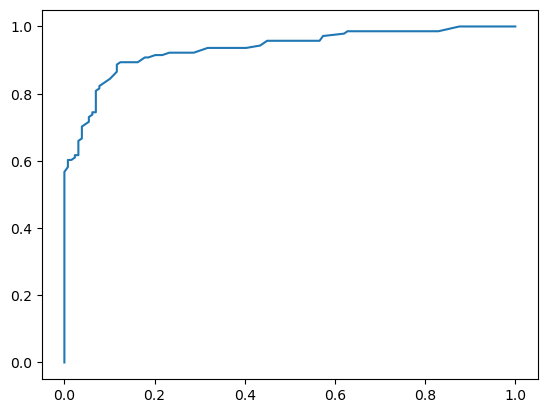

In [135]:
t = np.linspace(0, 1, 100)

xax = [fpr(sign(data.probs, j), data.classes) for j in t]
yax = [tpr(sign(data.probs, j), data.classes) for j in t]

plt.plot(xax, yax)